# Exploratory Data Analysis

## 1. Severe temperature changes per country

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Change this address to re-run the notebook locally
folder_name = '../data/kaggle_climate/'

In [3]:
# Load data
df = pd.read_csv(folder_name + 'GlobalLandTemperaturesByCountry.csv')
df['Date'] = pd.to_datetime(df.dt)
df.columns

Index(['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'Country',
       'Date'],
      dtype='object')

Let's make the following assumptions:
* Only consider data after 1900 (when data for most countries is available), and before 2013 (as most countries don't have numbers for 2013)
* Drop Antarctica (as it's not really a country, and it has no coverage anyway)
* Check if any data is still missing
* Aggregate (average) temperatures at a decade level.
* Ignore 2010-2012 data. We could extrapolate from 2 years, but it would be a very noisy estimation, compared to the rest of the data, and we don't want that.
* Visualize everything (just in case)

In [4]:
earliest_date = pd.to_datetime('1900-01-01')
latest_date = pd.to_datetime('2010-01-01')
dfc = (df
       .query("Date >= @earliest_date")
       .query("Date < @ latest_date")
       .query("Country != 'Antarctica'")
       .assign(Decade = (df.Date.dt.year // 10)*10)
       .groupby(['Country','Decade'])
       .agg({'AverageTemperature': 'mean'})
       .reset_index()
       .pivot_table(index='Decade', columns='Country', values='AverageTemperature', aggfunc='mean')
     )

dfc.shape

(11, 242)

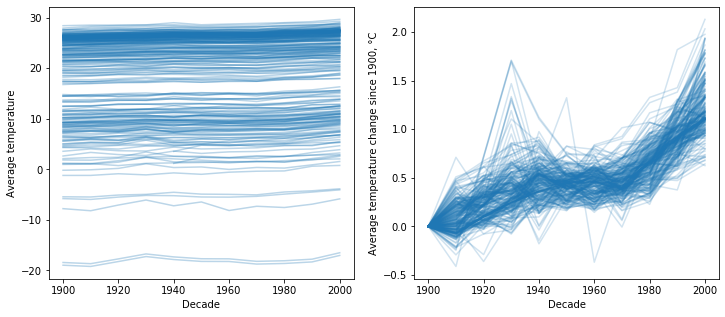

In [5]:
# Summary plots

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(dfc, color='tab:blue', alpha=0.3)
plt.xlabel('Decade')
plt.ylabel('Average temperature')
plt.subplot(122)
plt.plot(dfc.index, dfc.values[:,1:] - dfc.values[0,1:], color='tab:blue', alpha=0.2);
plt.xlabel('Decade')
plt.ylabel('Average temperature change since 1900, °C');

Now let's find several countries with most severe temperature change decade-to-decade. There are several ways to calculate something that would intuitively "feel" like decade-to-decade change, so let's consider 2 options:
1. Overall upwards trend (warming)
1. Overall variability (swing + trend)

In [6]:
def niceplot(df, countries):
    # Plot countries in the context
    plt.plot(df.index, df.values[:,1:] - df.values[0,1:], color='tab:gray', alpha=0.05, label=None);
    for name in countries:
        #ind = [i for i in range(df.shape[1]) if df.columns[i] in countries]
        ind = np.argwhere(df.columns==name).squeeze()        
        plt.plot(df.index, df.values[:,ind] - df.values[0,ind], label=name);
    plt.xlabel('Decade')
    plt.ylabel('Average temperature change since 1900, °C')
    plt.legend()

,Country,value
143,Mongolia,0.185521
114,Kazakhstan,0.177452
233,Uzbekistan,0.162870


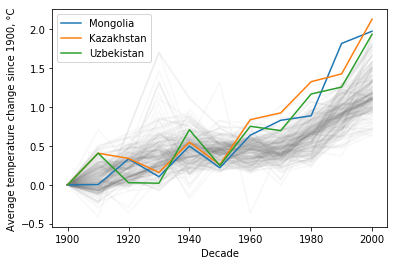

In [7]:
# Countries with biggest temperature changes
# Intepreted as a warming trend

def trend(x):
    if x.shape[0]==0: return 0
    x = x.values
    ind = np.argwhere(np.isnan(x))
    if len(ind)>0:        
        x[ind] = np.mean(x[~np.isnan(x)]) # Quick and dirty hack - replacing missing data with mean value for remaining data
    return np.polyfit(np.arange(len(x)), x, 1)[0]

out = (dfc
       .melt()
       .groupby('Country')
       .agg({'value': trend})
       .reset_index()
       .sort_values('value', ascending=False)
       .head(3)
      )
niceplot(dfc, out.Country.values)
out

,Country,value
209,Svalbard And Jan Mayen,0.780132
143,Mongolia,0.682812
87,Greenland,0.667848


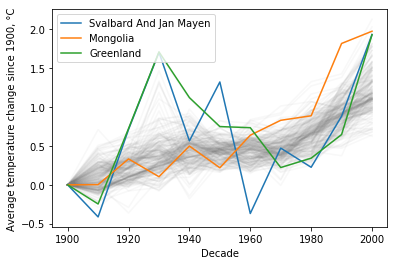

In [8]:
# Countries with biggest temperature changes
# Interpreted as total variability (both swing and trend):

out = (dfc
       .melt()
       .groupby('Country')
       .agg({'value': 'std'})
       .reset_index()
       .sort_values('value', ascending=False)
       .head(3)
      )
niceplot(dfc, out.Country.values)
out

Conclusion: **Mongolia** is a good candidate for the "Country with biggest change", as it leads both in terms of overall change, and upward trend.